<h4>
<ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">OBJECTIVE:</span></strong></li>
</ul>
<p><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Use the text data to build a deep-learning based binary classifier.</span></p>
    </h4>

In [1]:
# imports

import warnings
warnings.filterwarnings('ignore')

import os
import math
import random
from time import time
from pathlib import Path
import pandas as pd, numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud, STOPWORDS
import tensorflow

tqdm.pandas()
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# reproducibility
seed = 7
random.seed(seed)
tensorflow.random.set_seed(seed)

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Import the clean data.</span></strong></li>
</ul></h3>

In [3]:
dataset = pd.read_csv('./data/augmented_data.csv')
dataset.sample(10)

,Unnamed: 0,translated_description,keywords,short_description,description,group,cleaned_description,cleaned_short_description,merged_description,char_length,word_length,short_char_length,short_word_length,language,language_confidence,label
12681,4182,sync hr org details purchase dhmfuvgw jralkfcb...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
20884,5183,Prospects for the emission attack,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1795,1795,device properly boot window system hang user l...,device properly boot window system,device does not properly boot up windows - sys...,device does not properly boot up windows - sys...,GRP_28,device properly boot window system hang user l...,device properly boot window system hang user l...,device properly boot window system hang user l...,73.0,13.0,73.0,13.0,en,0.737592,1
8242,8242,fw opening ts link open etcal moment office et...,responsibility practice etcal habit click,fw: an ''ethical moment'' from the office of e...,hi\n\nthis link is not opening.\n\nfrom: .ethi...,GRP_0,ts link open etcal moment office etcs complian...,fw etcal moment office etcs compliance link op...,fw opening ts link open etcal moment office et...,506.0,72.0,86.0,14.0,en,0.601263,0
18226,2525,lhqwsf uses collaboration platform nologin ret...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6698,6698,erp difference review quantity attach order ac...,erp difference review quantity attach,erp order acknowledgement weight difference,\n\nreceived from: nuhfwplj.ojcwxser@gmail.com...,GRP_13,review quantity attach order acknowledgement q...,erp order acknowledgement weight difference,erp difference review quantity attach order ac...,303.0,47.0,43.0,5.0,en,0.574166,1
9188,689,for herrs detection use potsffwzlo va computer...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
16590,889,Restore password,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
22493,6792,bobj miss user t ability access report via i.e...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
15703,2,realpresence destop polycom desktop installati...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [4]:
dataset.isna().sum()

Unnamed: 0                       0
translated_description           0
keywords                     14336
short_description            14326
description                  14326
group                        14326
cleaned_description          14383
cleaned_short_description    14376
merged_description           14326
char_length                  14326
word_length                  14326
short_char_length            14326
short_word_length            14326
language                     14326
language_confidence          14326
label                            0
dtype: int64

In [5]:
dataset.label.value_counts()

0    13109
1     9716
Name: label, dtype: int64

In [6]:
X = np.array(dataset.translated_description)
y = np.array(dataset.label)
X.shape, y.shape

((22825,), (22825,))

In [7]:
from tensorflow.keras.utils import to_categorical
y_dummy_coded = to_categorical(y)
y[0], y_dummy_coded[0]

(0, array([1., 0.], dtype=float32))

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_dummy_coded, test_size=.15,
                                                    random_state=seed, stratify=y_dummy_coded)  # splits are stratified by y

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19401,), (3424,), (19401, 2), (3424, 2))

In [10]:
X_train[0], y_train[0]  # check sample

('company guest account work wch create yesterday',
 array([1., 0.], dtype=float32))

In [11]:
# TODO: Check the distributions of groups in training and testing sets, i.e, if they vary too much
# stratify by y if required during splits
# or data augmentation to upsample minority classes to balance the group distributions

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Tokenize and pad sequences</span></strong></li>
</ul></h3>

In [12]:
# define params
NUM_WORDS = 20000
EMBEDDING_DIM = 300
MAX_LEN = 100 # dataset['word_length'].max()
MAX_LEN

100

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(X_train)
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)
X_train_tokens[0], X_test_tokens[0]

([12, 691, 17, 2, 122, 65, 446], [1091, 2, 83, 2, 793, 29, 215])

In [14]:
y_train[0], y_test[0]

(array([1., 0.], dtype=float32), array([0., 1.], dtype=float32))

In [15]:
# pad sequences to cut longer texts to a uniform length and pad the sentences that are shorter than that with <PAD> token

# using just 20 words from each headline will severely limit the information that is 
# available to the model and affect performance although the training will be faster
X_train_padded = pad_sequences(X_train_tokens,
                               padding='post',
                               truncating='post',
                               maxlen=MAX_LEN)
X_test_padded = pad_sequences(X_test_tokens,
                              padding='post',
                              truncating='post',
                              maxlen=MAX_LEN)


print(f'X train:  {X_train_padded.shape}\nX test:   {X_test_padded.shape}')

X train:  (19401, 100)
X test:   (3424, 100)


In [16]:
pprint(X_train_padded[0], compact=True)

array([ 12, 691,  17,   2, 122,  65, 446,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0])


In [17]:
WORD_TO_INDEX = tokenizer.word_index
# pprint(WORD_TO_INDEX, compact=True)
pprint(list(WORD_TO_INDEX.keys())[:100], compact=True)

['u', 'work', 'the', 'password', 'ts', 'job', 'system', 'erp', 'tool', 'user',
 'security', 'company', 'plant', 'to', 'error', 'problem', 'account', 'access',
 'of', 'sid', 'printer', 'reset', 'need', 'use', 'ticket', 'get', 'help',
 'window', 'hostname', 'e', 'message', 'engineering', 'issue', 'email', 'time',
 'failure', 'site', 'change', 'scheduler', 'fail', 'order', 'name', 'new',
 'check', 'login', 'update', 'request', 'information', 'streaming', 'see',
 'unable', 'germany', 'contact', 'server', 'try', 'type', 'log', 'phone',
 'open', 'and', 'network', 'send', 'backup', 'call', 'create', 'crm', 'team',
 'report', 't', 'with', 'i', 'show', 'connection', 'pc', 'circuit', 'outlook',
 'a', 'connect', 'view', 'management', 'number', 'file', 'programmer', 'is',
 'print', 'not', 'receive', 'could', 'no', 'able', 'in', 'start', 'mail', 'vpn',
 'maintenance', 'lock', 'ms', 'device', 'computer', 'also']


In [18]:
VOCAB_SIZE = len(WORD_TO_INDEX) + 1
VOCAB_SIZE

13243

In [19]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def retrieve_description_feat(x, mapping=WORD_TO_INDEX) -> str:
    # increment 3 
    mapping = {k:(v + 3) for k, v in mapping.items()}
    mapping['<PAD>'] = 0
    mapping['<START>'] = 1
    mapping['<UNK>'] = 2
    inv_mapping = {v: k for k, v in mapping.items()}
    return str(" ".join(inv_mapping.get(i, '<NA>') for i in x))

retrieve_description_feat(X_test_padded[7])

'fields reset power vlan <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">GloVe Embeddings</span></strong></li>
</ul></h3>

In [20]:
EMBEDDING_DIM

300

In [21]:
def get_embedding_matrix(embedding_dim=EMBEDDING_DIM):
    embeddings = defaultdict()
    if embedding_dim == 200:
        file_path = f'./data/glove.6B.{embedding_dim}d.txt'
    elif embedding_dim == 300:
        file_path = f'./data/glove.840B.{embedding_dim}d.txt'
    for l in open(file_path, encoding='utf-8'):
        word = l.split(" ")[0]
        embeddings[word] = np.asarray(l.split(" ")[1:], dtype='float32')

    embeddings = dict(embeddings)

    # create a weight matrix for words in training docs
    embedding_matrix = np.zeros((NUM_WORDS, embedding_dim))

    for word, idx in WORD_TO_INDEX.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [22]:
# use pre-trained glove embedding matrix to initialize weights in our model
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(20000, 300)

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Simple Feed-Forward Neural Net</span></strong></li>
</ul></h4>

In [23]:
# !pip install livelossplot
from tensorflow.python.keras.models import Sequential
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm, unit_norm
from tensorflow.python.keras.callbacks import LambdaCallback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Activation, BatchNormalization, Dropout, Embedding, LSTM, MaxPooling1D, Conv1D, Bidirectional

In [24]:
NUM_CLASSES = 2
VOCAB_SIZE, MAX_LEN, EMBEDDING_DIM, NUM_CLASSES

(13243, 100, 300, 2)

In [25]:
# define model

model1 = Sequential([ 
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dense(1024, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model1.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [26]:
# Define Callbacks and a few helper functions

# simplify the training log
simple_log = LambdaCallback(
    on_epoch_end = lambda e, l: print(f" ~| Epoch: {e+1} | Validation Loss: {l['val_loss']:.5f}", end =" >|> \n" ))

# early stopping
early_stop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=7,
                              verbose=0, 
                              restore_best_weights=True)

# learning rate reduction
lr_reduce_on_plateau = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.4,
                                            min_lr=0.00001)

def plot_learning_curve(hist):
    sns.set()
    plt.figure(figsize=(5,5))
    train = hist.history['loss']
    val = hist.history['val_loss']
    epochs_run = range(1,len(train) + 1)
    sns.lineplot(epochs_run, train, marker = 'o', color = 'coral', label = 'Training Loss')
    sns.lineplot(epochs_run, val,  marker = '>', color = 'green', label = 'Validation Loss')
    plt.title("Loss vs. Epochs", fontsize = 20)
    plt.legend()
    plt.show()

In [27]:
X_train[0]

'company guest account work wch create yesterday'

In [28]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19401,), (19401, 2), (3424,), (3424, 2))

In [29]:
EPOCHS = 200
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h1 = model1.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)
except Exception as e:
    print(e)
    print("\nTraining on CPU:")
    h1 = model1.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.27881 >|> 
 ~| Epoch: 2 | Validation Loss: 0.35639 >|> 
 ~| Epoch: 3 | Validation Loss: 0.35329 >|> 
 ~| Epoch: 4 | Validation Loss: 0.34638 >|> 
 ~| Epoch: 5 | Validation Loss: 0.45027 >|> 
 ~| Epoch: 6 | Validation Loss: 0.40166 >|> 
 ~| Epoch: 7 | Validation Loss: 0.47374 >|> 
 ~| Epoch: 8 | Validation Loss: 0.48853 >|> 

Training Done.


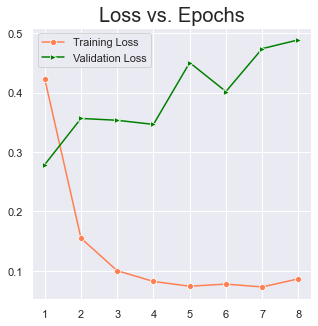

In [30]:
plot_learning_curve(h1)

In [31]:
loss, acc = model1.evaluate(X_test_padded, y_test)
print("Testing Loss: ", loss*100)
print("Testing Accuracy: ", acc*100)

107/107 [==============================] - 0s 3ms/step - loss: 0.2925 - accuracy: 0.8808
Testing Loss:  29.250219464302063
Testing Accuracy:  88.08411359786987


<h4><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>This model is clearly overfitting, we will add regularization to the next iteration
 </span></ul></h4>

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Simple Feed-Forward Neural Net + Batch Normalization</span></strong></li>
</ul></h4>

In [32]:
# define model

model2 = Sequential([ 
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Flatten(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model2.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [33]:
EPOCHS = 200
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h2 = model2.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h2 = model2.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.30949 >|> 
 ~| Epoch: 2 | Validation Loss: 1.11575 >|> 
 ~| Epoch: 3 | Validation Loss: 0.40421 >|> 
 ~| Epoch: 4 | Validation Loss: 0.49249 >|> 
 ~| Epoch: 5 | Validation Loss: 0.36853 >|> 
 ~| Epoch: 6 | Validation Loss: 0.31886 >|> 
 ~| Epoch: 7 | Validation Loss: 0.45799 >|> 
 ~| Epoch: 8 | Validation Loss: 0.35638 >|> 

Training Done.


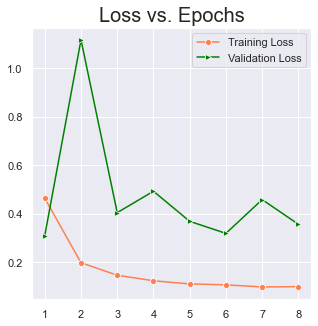

In [34]:
plot_learning_curve(h2)

In [35]:
loss, acc = model2.evaluate(X_test_padded, y_test)
print("Testing Loss: ", loss*100)
print("Testing Accuracy: ", acc*100)

107/107 [==============================] - 0s 3ms/step - loss: 0.3225 - accuracy: 0.8721
Testing Loss:  32.250216603279114
Testing Accuracy:  87.20794320106506


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Simple Feed-Forward Neural Net + Dropout</span></strong></li>
</ul></h4>

In [36]:
# define model

model3 = Sequential([ 
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Flatten(),
    Dense(20, activation = 'relu'),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model3.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [37]:
EPOCHS = 200
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h3 = model3.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h3 = model3.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.29352 >|> 
 ~| Epoch: 2 | Validation Loss: 0.26116 >|> 
 ~| Epoch: 3 | Validation Loss: 0.28308 >|> 
 ~| Epoch: 4 | Validation Loss: 0.30607 >|> 
 ~| Epoch: 5 | Validation Loss: 0.37347 >|> 
 ~| Epoch: 6 | Validation Loss: 0.35112 >|> 

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
 ~| Epoch: 7 | Validation Loss: 0.44149 >|> 
 ~| Epoch: 8 | Validation Loss: 0.42532 >|> 
 ~| Epoch: 9 | Validation Loss: 0.44004 >|> 

Training Done.


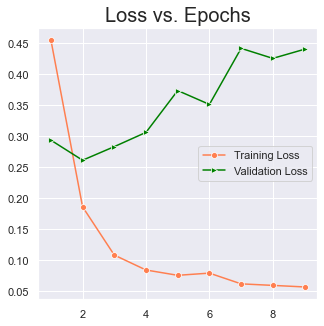

In [38]:
plot_learning_curve(h3)

In [39]:
loss, acc = model3.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

107/107 [==============================] - 0s 3ms/step - loss: 0.2660 - accuracy: 0.8981
Testing Accuracy:  89.80724215507507


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Use pre-trained embeddings</span></strong></li>
</ul></h4>

In [40]:
# define model

model3 = Sequential([ 
    Embedding(input_dim=NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN, weights=[embedding_matrix], trainable=True),
    Flatten(),
    Dense(30, activation = 'relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model3.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['accuracy']
)

In [41]:
EPOCHS = 200
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h3 = model3.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h3 = model3.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.43302 >|> 
 ~| Epoch: 2 | Validation Loss: 0.37491 >|> 
 ~| Epoch: 3 | Validation Loss: 0.38057 >|> 
 ~| Epoch: 4 | Validation Loss: 0.36763 >|> 
 ~| Epoch: 5 | Validation Loss: 0.39535 >|> 
 ~| Epoch: 6 | Validation Loss: 0.44507 >|> 
 ~| Epoch: 7 | Validation Loss: 0.46711 >|> 
 ~| Epoch: 8 | Validation Loss: 0.51175 >|> 
 ~| Epoch: 9 | Validation Loss: 0.57345 >|> 
 ~| Epoch: 10 | Validation Loss: 0.59302 >|> 
 ~| Epoch: 11 | Validation Loss: 0.68409 >|> 

Training Done.


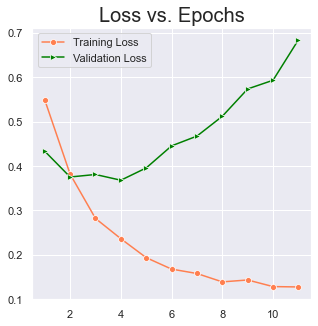

In [42]:
plot_learning_curve(h3)

In [43]:
loss, acc = model3.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

107/107 [==============================] - 0s 3ms/step - loss: 0.3664 - accuracy: 0.8639
Testing Accuracy:  86.39018535614014


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">LSTM</span></strong></li>
</ul></h4>

In [44]:
# define model

model4 = Sequential([ 
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    LSTM(32),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model4.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [45]:
EPOCHS = 50
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h4 = model4.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, lr_reduce_on_plateau],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h4 = model4.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.68317 >|> 
 ~| Epoch: 2 | Validation Loss: 0.68206 >|> 
 ~| Epoch: 3 | Validation Loss: 0.68186 >|> 
 ~| Epoch: 4 | Validation Loss: 0.68319 >|> 
 ~| Epoch: 5 | Validation Loss: 0.68305 >|> 
 ~| Epoch: 6 | Validation Loss: 0.52422 >|> 
 ~| Epoch: 7 | Validation Loss: 0.42035 >|> 
 ~| Epoch: 8 | Validation Loss: 0.33267 >|> 
 ~| Epoch: 9 | Validation Loss: 0.31557 >|> 
 ~| Epoch: 10 | Validation Loss: 0.27365 >|> 
 ~| Epoch: 11 | Validation Loss: 0.28261 >|> 
 ~| Epoch: 12 | Validation Loss: 0.31137 >|> 
 ~| Epoch: 13 | Validation Loss: 0.31233 >|> 
 ~| Epoch: 14 | Validation Loss: 0.36619 >|> 

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
 ~| Epoch: 15 | Validation Loss: 0.35220 >|> 
 ~| Epoch: 16 | Validation Loss: 0.35495 >|> 
 ~| Epoch: 17 | Validation Loss: 0.38389 >|> 
 ~| Epoch: 18 | Validation Loss: 0.40554 >|> 

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00016000000759959222.
 

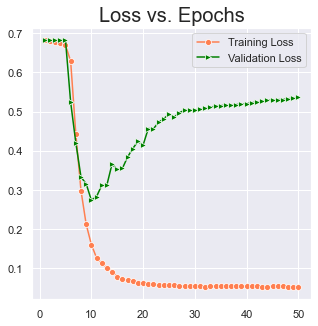

In [46]:
plot_learning_curve(h4)

In [47]:
loss, acc = model4.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

107/107 [==============================] - 1s 4ms/step - loss: 0.5772 - accuracy: 0.9051
Testing Accuracy:  90.50817489624023


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Bi-Directional LSTM</span></strong></li>
</ul></h4>

In [48]:
# define model

model4 = Sequential([ 
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(32)),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model4.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['accuracy']
)

In [49]:
EPOCHS = 200
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h4 = model4.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h4 = model4.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.38326 >|> 
 ~| Epoch: 2 | Validation Loss: 0.33462 >|> 
 ~| Epoch: 3 | Validation Loss: 0.29639 >|> 
 ~| Epoch: 4 | Validation Loss: 0.27754 >|> 
 ~| Epoch: 5 | Validation Loss: 0.26626 >|> 
 ~| Epoch: 6 | Validation Loss: 0.26179 >|> 
 ~| Epoch: 7 | Validation Loss: 0.26170 >|> 
 ~| Epoch: 8 | Validation Loss: 0.25741 >|> 
 ~| Epoch: 9 | Validation Loss: 0.26233 >|> 
 ~| Epoch: 10 | Validation Loss: 0.25802 >|> 
 ~| Epoch: 11 | Validation Loss: 0.26527 >|> 
 ~| Epoch: 12 | Validation Loss: 0.26446 >|> 

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
 ~| Epoch: 13 | Validation Loss: 0.26267 >|> 
 ~| Epoch: 14 | Validation Loss: 0.27416 >|> 
 ~| Epoch: 15 | Validation Loss: 0.26413 >|> 

Training Done.


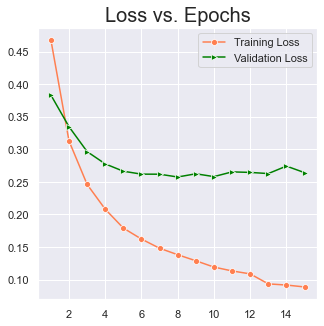

In [50]:
plot_learning_curve(h4)

In [51]:
loss, acc = model4.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

107/107 [==============================] - 1s 7ms/step - loss: 0.2983 - accuracy: 0.8943
Testing Accuracy:  89.42757248878479


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">CNN (Dimensionality Reduction) + LSTM</span></strong></li>
</ul></h4>

In [52]:
model5 = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=256, input_length=MAX_LEN),
    Dropout(0.25),
    Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1),
    Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1),
    MaxPooling1D(pool_size = 2),
    Conv1D(64, 5, padding = 'same', activation = 'relu', strides = 1),
    MaxPooling1D(pool_size = 2),
    LSTM(75),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model5.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [53]:
EPOCHS = 20
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h5 = model5.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h5 = model5.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.40154 >|> 
 ~| Epoch: 2 | Validation Loss: 0.29378 >|> 
 ~| Epoch: 3 | Validation Loss: 0.28255 >|> 
 ~| Epoch: 4 | Validation Loss: 0.29477 >|> 
 ~| Epoch: 5 | Validation Loss: 0.28189 >|> 
 ~| Epoch: 6 | Validation Loss: 0.27847 >|> 
 ~| Epoch: 7 | Validation Loss: 0.31306 >|> 
 ~| Epoch: 8 | Validation Loss: 0.31734 >|> 
 ~| Epoch: 9 | Validation Loss: 0.31028 >|> 
 ~| Epoch: 10 | Validation Loss: 0.30491 >|> 

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
 ~| Epoch: 11 | Validation Loss: 0.33975 >|> 
 ~| Epoch: 12 | Validation Loss: 0.37008 >|> 
 ~| Epoch: 13 | Validation Loss: 0.35614 >|> 

Training Done.


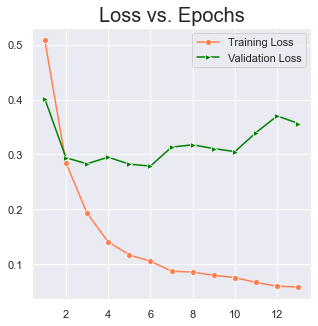

In [54]:
plot_learning_curve(h5)

In [55]:
loss, acc = model5.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

107/107 [==============================] - 1s 5ms/step - loss: 0.2931 - accuracy: 0.9019
Testing Accuracy:  90.18691778182983


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">CNN (Dimensionality Reduction) + Bi-Directional LSTM</span></strong></li>
</ul></h4>

In [56]:
model5 = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=256, input_length=MAX_LEN),
    Dropout(0.25),
    Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1),
    Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1),
    MaxPooling1D(pool_size = 2),
    Conv1D(64, 5, padding = 'same', activation = 'relu', strides = 1),
    MaxPooling1D(pool_size = 2),
    Bidirectional(LSTM(75, recurrent_dropout=0.5)),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model5.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [57]:
EPOCHS = 20
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h5 = model5.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h5 = model5.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.32444 >|> 
 ~| Epoch: 2 | Validation Loss: 0.27999 >|> 
 ~| Epoch: 3 | Validation Loss: 0.26327 >|> 
 ~| Epoch: 4 | Validation Loss: 0.28086 >|> 
 ~| Epoch: 5 | Validation Loss: 0.27875 >|> 
 ~| Epoch: 6 | Validation Loss: 0.30258 >|> 
 ~| Epoch: 7 | Validation Loss: 0.30559 >|> 
 ~| Epoch: 8 | Validation Loss: 0.29836 >|> 
 ~| Epoch: 9 | Validation Loss: 0.36239 >|> 
 ~| Epoch: 10 | Validation Loss: 0.32978 >|> 

Training Done.


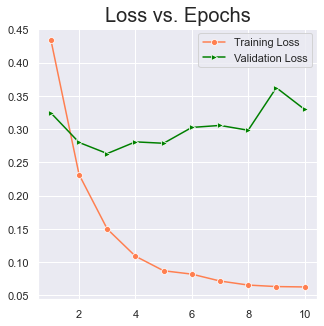

In [58]:
plot_learning_curve(h5)

In [59]:
loss, acc = model5.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

107/107 [==============================] - 5s 43ms/step - loss: 0.2711 - accuracy: 0.8957
Testing Accuracy:  89.57359790802002


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Use TfIdf vectors instead of Embedding Layer + Feature Selection</span></strong></li>
</ul></h4>

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# using 75-25 split instead of 50-50 split as we need more data to train neural nets
X_train_vec, X_test_vec, y_train_vec, y_test_vec = train_test_split(X, y, test_size=0.15, random_state=seed, stratify=y)
print(f"Train dataset shape: {X_train_vec.shape}, \nTest dataset shape: {X_test_vec.shape}")

Train dataset shape: (19401,), 
Test dataset shape: (3424,)


In [61]:
NGRAM_RANGE = (1, 3)
TOP_K = 8500
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2


kwargs = {
    'ngram_range' : NGRAM_RANGE,
    'dtype' : 'int32',
    'strip_accents' : 'unicode',
    'decode_error' : 'replace',
    'analyzer' : TOKEN_MODE,
    'min_df' : MIN_DOC_FREQ
}
vectorizer = TfidfVectorizer(**kwargs)
X_train_vec = vectorizer.fit_transform(X_train_vec)
X_test_vec = vectorizer.transform(X_test_vec)
print(f"Train dataset shape: {X_train_vec.shape}, \nTest dataset shape: {X_test_vec.shape}")

Train dataset shape: (19401, 98751), 
Test dataset shape: (3424, 98751)


In [62]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select best k features, with feature importance measured by f_classif
# Set k as 20000 or (if number of ngrams is less) number of ngrams   
selector = SelectKBest(f_classif, k=min(TOP_K, X_train_vec.shape[1]))
selector.fit(X_train_vec, y_train_vec)
X_train_vec = selector.transform(X_train_vec).astype('float32')
X_test_vec = selector.transform(X_test_vec).astype('float32')
X_train_vec = X_train_vec.toarray()
X_test_vec = X_test_vec.toarray()

print(f"Train dataset shape: {X_train_vec.shape}, \nTest dataset shape: {X_test_vec.shape}")

Train dataset shape: (19401, 8500), 
Test dataset shape: (3424, 8500)


In [63]:
model6 = Sequential([
    Dense(30, activation='relu', input_shape=X_train_vec.shape[1:]),
    Dropout(0.5),
    Dense(20, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model6.compile(
    loss = 'binary_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['accuracy']
)

In [68]:
EPOCHS = 50
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h6 = model6.fit(
            X_train_vec, y_train_vec,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)
except Exception:
    print("Training on CPU:")
    h6 = model6.fit(
            X_train_vec, y_train_vec,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.34213 >|> 
 ~| Epoch: 2 | Validation Loss: 0.34499 >|> 
 ~| Epoch: 3 | Validation Loss: 0.34764 >|> 
 ~| Epoch: 4 | Validation Loss: 0.34054 >|> 
 ~| Epoch: 5 | Validation Loss: 0.34620 >|> 
 ~| Epoch: 6 | Validation Loss: 0.34439 >|> 
 ~| Epoch: 7 | Validation Loss: 0.34553 >|> 
 ~| Epoch: 8 | Validation Loss: 0.34441 >|> 
 ~| Epoch: 9 | Validation Loss: 0.34179 >|> 
 ~| Epoch: 10 | Validation Loss: 0.34322 >|> 
 ~| Epoch: 11 | Validation Loss: 0.34504 >|> 

Training Done.


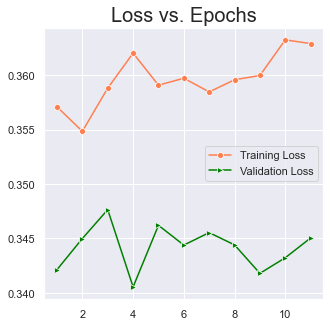

In [69]:
plot_learning_curve(h6)

In [70]:
loss, acc = model6.evaluate(X_test_vec, y_test_vec)
print("Testing Accuracy: ", acc*100)

107/107 [==============================] - 0s 2ms/step - loss: 0.4095 - accuracy: 0.8435
Testing Accuracy:  84.34579372406006


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Use TfIdf vectors instead of Embedding Layer + Feature Selection + Stratified KFold Training</span></strong></li>
</ul></h4>


Train dataset shape: (21912, 56906), 
Test dataset shape: (913, 56906)

Features Train dataset shape: (21912, 15000), 
FeaturesTest dataset shape: (913, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.85761, saving model to models\binary_classfiier\dl\merged_descr\model_1.h5

Epoch 00002: val_accuracy improved from 0.85761 to 0.88061, saving model to models\binary_classfiier\dl\merged_descr\model_1.h5

Epoch 00003: val_accuracy improved from 0.88061 to 0.89157, saving model to models\binary_classfiier\dl\merged_descr\model_1.h5

Epoch 00004: val_accuracy improved from 0.89157 to 0.89704, saving model to models\binary_classfiier\dl\merged_descr\model_1.h5

Epoch 00005: val_accuracy did not improve from 0.89704

Epoch 00006: val_accuracy improved from 0.89704 to 0.90033, saving model to models\binary_classfiier\dl\merged_descr\model_1.h5

Epoch 00007: val_accuracy improved from 0.90033 to 0.90142, saving model to models\binary_classfiier\dl\merged_descr\model_1.h5

Epoch 00008

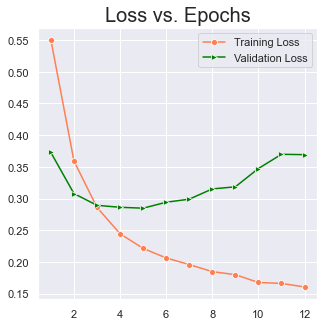

29/29 [==============================] - 0s 2ms/step - loss: 0.3692 - accuracy: 0.9102
Testing Accuracy:  91.01861715316772

Train dataset shape: (21912, 56792), 
Test dataset shape: (913, 56792)

Features Train dataset shape: (21912, 15000), 
FeaturesTest dataset shape: (913, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.85652, saving model to models\binary_classfiier\dl\merged_descr\model_2.h5

Epoch 00002: val_accuracy improved from 0.85652 to 0.89266, saving model to models\binary_classfiier\dl\merged_descr\model_2.h5

Epoch 00003: val_accuracy improved from 0.89266 to 0.89485, saving model to models\binary_classfiier\dl\merged_descr\model_2.h5

Epoch 00004: val_accuracy improved from 0.89485 to 0.89704, saving model to models\binary_classfiier\dl\merged_descr\model_2.h5

Epoch 00005: val_accuracy improved from 0.89704 to 0.90581, saving model to models\binary_classfiier\dl\merged_descr\model_2.h5

Epoch 00006: val_accuracy improved from 0.90581 to 0.90800, saving model

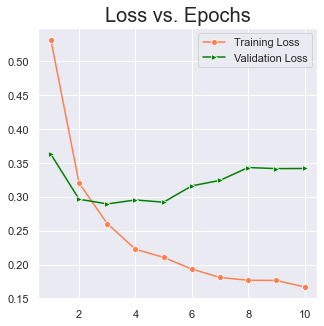

29/29 [==============================] - 0s 3ms/step - loss: 0.3417 - accuracy: 0.9200
Testing Accuracy:  92.00438261032104

Train dataset shape: (21912, 56604), 
Test dataset shape: (913, 56604)

Features Train dataset shape: (21912, 15000), 
FeaturesTest dataset shape: (913, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.84995, saving model to models\binary_classfiier\dl\merged_descr\model_3.h5

Epoch 00002: val_accuracy improved from 0.84995 to 0.87842, saving model to models\binary_classfiier\dl\merged_descr\model_3.h5

Epoch 00003: val_accuracy improved from 0.87842 to 0.89923, saving model to models\binary_classfiier\dl\merged_descr\model_3.h5

Epoch 00004: val_accuracy did not improve from 0.89923

Epoch 00005: val_accuracy did not improve from 0.89923

Epoch 00006: val_accuracy improved from 0.89923 to 0.90361, saving model to models\binary_classfiier\dl\merged_descr\model_3.h5

Epoch 00007: val_accuracy improved from 0.90361 to 0.90690, saving model to models\binary

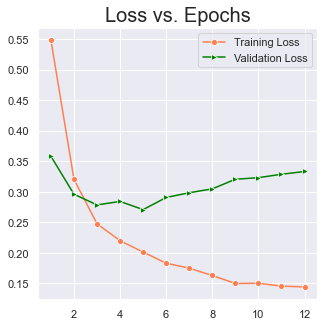

29/29 [==============================] - 0s 3ms/step - loss: 0.3333 - accuracy: 0.9135
Testing Accuracy:  91.3472056388855

Train dataset shape: (21912, 56982), 
Test dataset shape: (913, 56982)

Features Train dataset shape: (21912, 15000), 
FeaturesTest dataset shape: (913, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.85214, saving model to models\binary_classfiier\dl\merged_descr\model_4.h5

Epoch 00002: val_accuracy improved from 0.85214 to 0.88719, saving model to models\binary_classfiier\dl\merged_descr\model_4.h5

Epoch 00003: val_accuracy improved from 0.88719 to 0.89047, saving model to models\binary_classfiier\dl\merged_descr\model_4.h5

Epoch 00004: val_accuracy improved from 0.89047 to 0.89923, saving model to models\binary_classfiier\dl\merged_descr\model_4.h5

Epoch 00005: val_accuracy improved from 0.89923 to 0.90033, saving model to models\binary_classfiier\dl\merged_descr\model_4.h5

Epoch 00006: val_accuracy improved from 0.90033 to 0.90471, saving model 

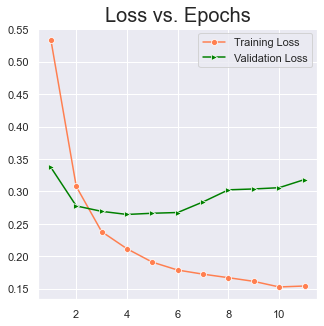

29/29 [==============================] - 0s 3ms/step - loss: 0.3038 - accuracy: 0.9124
Testing Accuracy:  91.23767614364624

Train dataset shape: (21912, 56878), 
Test dataset shape: (913, 56878)

Features Train dataset shape: (21912, 15000), 
FeaturesTest dataset shape: (913, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.86528, saving model to models\binary_classfiier\dl\merged_descr\model_5.h5

Epoch 00002: val_accuracy improved from 0.86528 to 0.88938, saving model to models\binary_classfiier\dl\merged_descr\model_5.h5

Epoch 00003: val_accuracy improved from 0.88938 to 0.89814, saving model to models\binary_classfiier\dl\merged_descr\model_5.h5

Epoch 00004: val_accuracy improved from 0.89814 to 0.90252, saving model to models\binary_classfiier\dl\merged_descr\model_5.h5

Epoch 00005: val_accuracy improved from 0.90252 to 0.91457, saving model to models\binary_classfiier\dl\merged_descr\model_5.h5

Epoch 00006: val_accuracy did not improve from 0.91457

Epoch 00007: val

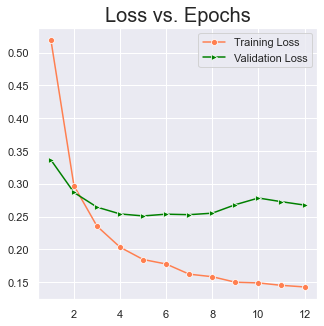

29/29 [==============================] - 0s 3ms/step - loss: 0.2675 - accuracy: 0.9157
Testing Accuracy:  91.56626462936401

Train dataset shape: (21912, 56909), 
Test dataset shape: (913, 56909)

Features Train dataset shape: (21912, 15000), 
FeaturesTest dataset shape: (913, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.87952, saving model to models\binary_classfiier\dl\merged_descr\model_6.h5

Epoch 00002: val_accuracy improved from 0.87952 to 0.90142, saving model to models\binary_classfiier\dl\merged_descr\model_6.h5

Epoch 00003: val_accuracy improved from 0.90142 to 0.90581, saving model to models\binary_classfiier\dl\merged_descr\model_6.h5

Epoch 00004: val_accuracy improved from 0.90581 to 0.91238, saving model to models\binary_classfiier\dl\merged_descr\model_6.h5

Epoch 00005: val_accuracy improved from 0.91238 to 0.92114, saving model to models\binary_classfiier\dl\merged_descr\model_6.h5

Epoch 00006: val_accuracy improved from 0.92114 to 0.92442, saving model

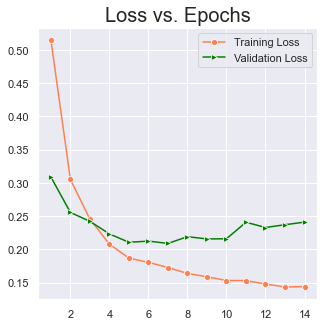

29/29 [==============================] - 0s 3ms/step - loss: 0.2411 - accuracy: 0.9376
Testing Accuracy:  93.75684261322021

Train dataset shape: (21912, 56844), 
Test dataset shape: (913, 56844)

Features Train dataset shape: (21912, 15000), 
FeaturesTest dataset shape: (913, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.87185, saving model to models\binary_classfiier\dl\merged_descr\model_7.h5

Epoch 00002: val_accuracy improved from 0.87185 to 0.90252, saving model to models\binary_classfiier\dl\merged_descr\model_7.h5

Epoch 00003: val_accuracy improved from 0.90252 to 0.90690, saving model to models\binary_classfiier\dl\merged_descr\model_7.h5

Epoch 00004: val_accuracy did not improve from 0.90690

Epoch 00005: val_accuracy improved from 0.90690 to 0.92223, saving model to models\binary_classfiier\dl\merged_descr\model_7.h5

Epoch 00006: val_accuracy did not improve from 0.92223

Epoch 00007: val_accuracy did not improve from 0.92223

Epoch 00008: val_accuracy did not

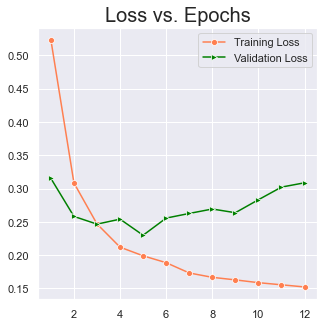

29/29 [==============================] - 0s 3ms/step - loss: 0.2299 - accuracy: 0.9222
Testing Accuracy:  92.22344160079956

Train dataset shape: (21912, 56414), 
Test dataset shape: (913, 56414)

Features Train dataset shape: (21912, 15000), 
FeaturesTest dataset shape: (913, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.86309, saving model to models\binary_classfiier\dl\merged_descr\model_8.h5

Epoch 00002: val_accuracy improved from 0.86309 to 0.89595, saving model to models\binary_classfiier\dl\merged_descr\model_8.h5

Epoch 00003: val_accuracy improved from 0.89595 to 0.90033, saving model to models\binary_classfiier\dl\merged_descr\model_8.h5

Epoch 00004: val_accuracy improved from 0.90033 to 0.91238, saving model to models\binary_classfiier\dl\merged_descr\model_8.h5

Epoch 00005: val_accuracy did not improve from 0.91238

Epoch 00006: val_accuracy did not improve from 0.91238

Epoch 00007: val_accuracy improved from 0.91238 to 0.91347, saving model to models\binary

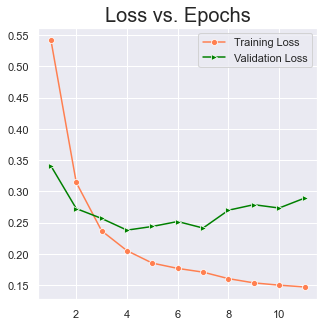

29/29 [==============================] - 0s 3ms/step - loss: 0.2734 - accuracy: 0.9157
Testing Accuracy:  91.56626462936401

Train dataset shape: (21912, 56866), 
Test dataset shape: (913, 56866)

Features Train dataset shape: (21912, 15000), 
FeaturesTest dataset shape: (913, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.85104, saving model to models\binary_classfiier\dl\merged_descr\model_9.h5

Epoch 00002: val_accuracy improved from 0.85104 to 0.87514, saving model to models\binary_classfiier\dl\merged_descr\model_9.h5

Epoch 00003: val_accuracy improved from 0.87514 to 0.88499, saving model to models\binary_classfiier\dl\merged_descr\model_9.h5

Epoch 00004: val_accuracy improved from 0.88499 to 0.89157, saving model to models\binary_classfiier\dl\merged_descr\model_9.h5

Epoch 00005: val_accuracy improved from 0.89157 to 0.90033, saving model to models\binary_classfiier\dl\merged_descr\model_9.h5

Epoch 00006: val_accuracy improved from 0.90033 to 0.90142, saving model

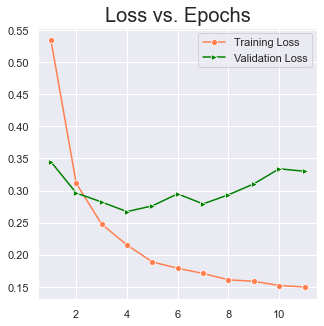

29/29 [==============================] - 0s 3ms/step - loss: 0.2934 - accuracy: 0.9124
Testing Accuracy:  91.23767614364624

Train dataset shape: (21912, 56826), 
Test dataset shape: (913, 56826)

Features Train dataset shape: (21912, 15000), 
FeaturesTest dataset shape: (913, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.85871, saving model to models\binary_classfiier\dl\merged_descr\model_10.h5

Epoch 00002: val_accuracy improved from 0.85871 to 0.88280, saving model to models\binary_classfiier\dl\merged_descr\model_10.h5

Epoch 00003: val_accuracy improved from 0.88280 to 0.90361, saving model to models\binary_classfiier\dl\merged_descr\model_10.h5

Epoch 00004: val_accuracy improved from 0.90361 to 0.90581, saving model to models\binary_classfiier\dl\merged_descr\model_10.h5

Epoch 00005: val_accuracy improved from 0.90581 to 0.91676, saving model to models\binary_classfiier\dl\merged_descr\model_10.h5

Epoch 00006: val_accuracy did not improve from 0.91676

Epoch 00007

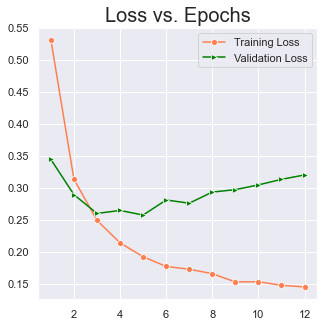

29/29 [==============================] - 0s 3ms/step - loss: 0.2572 - accuracy: 0.9168
Testing Accuracy:  91.67579412460327

Train dataset shape: (21912, 56842), 
Test dataset shape: (913, 56842)

Features Train dataset shape: (21912, 15000), 
FeaturesTest dataset shape: (913, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.84447, saving model to models\binary_classfiier\dl\merged_descr\model_11.h5

Epoch 00002: val_accuracy improved from 0.84447 to 0.86309, saving model to models\binary_classfiier\dl\merged_descr\model_11.h5

Epoch 00003: val_accuracy improved from 0.86309 to 0.87623, saving model to models\binary_classfiier\dl\merged_descr\model_11.h5

Epoch 00004: val_accuracy improved from 0.87623 to 0.88499, saving model to models\binary_classfiier\dl\merged_descr\model_11.h5

Epoch 00005: val_accuracy improved from 0.88499 to 0.89157, saving model to models\binary_classfiier\dl\merged_descr\model_11.h5

Epoch 00006: val_accuracy improved from 0.89157 to 0.89266, saving 

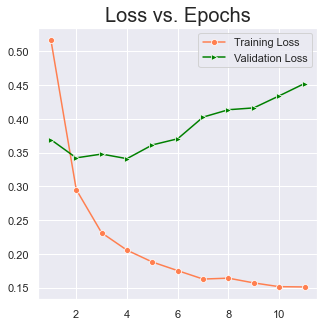

29/29 [==============================] - 0s 2ms/step - loss: 0.4525 - accuracy: 0.8959
Testing Accuracy:  89.59473967552185

Train dataset shape: (21912, 56883), 
Test dataset shape: (913, 56883)

Features Train dataset shape: (21912, 15000), 
FeaturesTest dataset shape: (913, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.85542, saving model to models\binary_classfiier\dl\merged_descr\model_12.h5

Epoch 00002: val_accuracy improved from 0.85542 to 0.88499, saving model to models\binary_classfiier\dl\merged_descr\model_12.h5

Epoch 00003: val_accuracy did not improve from 0.88499

Epoch 00004: val_accuracy improved from 0.88499 to 0.89047, saving model to models\binary_classfiier\dl\merged_descr\model_12.h5

Epoch 00005: val_accuracy improved from 0.89047 to 0.89157, saving model to models\binary_classfiier\dl\merged_descr\model_12.h5

Epoch 00006: val_accuracy improved from 0.89157 to 0.89923, saving model to models\binary_classfiier\dl\merged_descr\model_12.h5

Epoch 00007

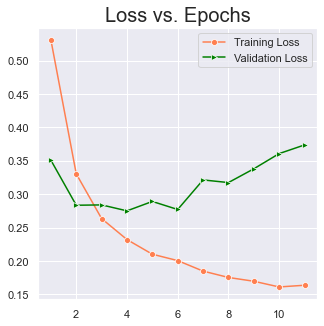

29/29 [==============================] - 0s 3ms/step - loss: 0.2770 - accuracy: 0.8992
Testing Accuracy:  89.92332816123962

Train dataset shape: (21912, 56712), 
Test dataset shape: (913, 56712)

Features Train dataset shape: (21912, 15000), 
FeaturesTest dataset shape: (913, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.85652, saving model to models\binary_classfiier\dl\merged_descr\model_13.h5

Epoch 00002: val_accuracy improved from 0.85652 to 0.87295, saving model to models\binary_classfiier\dl\merged_descr\model_13.h5

Epoch 00003: val_accuracy improved from 0.87295 to 0.88719, saving model to models\binary_classfiier\dl\merged_descr\model_13.h5

Epoch 00004: val_accuracy did not improve from 0.88719

Epoch 00005: val_accuracy did not improve from 0.88719

Epoch 00006: val_accuracy did not improve from 0.88719

Epoch 00007: val_accuracy improved from 0.88719 to 0.88938, saving model to models\binary_classfiier\dl\merged_descr\model_13.h5

Epoch 00008: val_accuracy imp

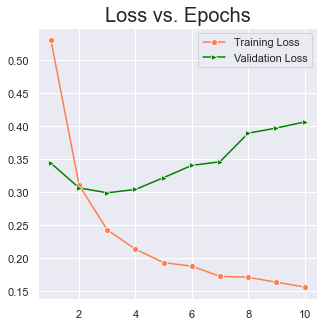

29/29 [==============================] - 0s 3ms/step - loss: 0.3968 - accuracy: 0.8959
Testing Accuracy:  89.59473967552185

Train dataset shape: (21912, 56911), 
Test dataset shape: (913, 56911)

Features Train dataset shape: (21912, 15000), 
FeaturesTest dataset shape: (913, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.88499, saving model to models\binary_classfiier\dl\merged_descr\model_14.h5

Epoch 00002: val_accuracy improved from 0.88499 to 0.90581, saving model to models\binary_classfiier\dl\merged_descr\model_14.h5

Epoch 00003: val_accuracy improved from 0.90581 to 0.91128, saving model to models\binary_classfiier\dl\merged_descr\model_14.h5

Epoch 00004: val_accuracy improved from 0.91128 to 0.92223, saving model to models\binary_classfiier\dl\merged_descr\model_14.h5

Epoch 00005: val_accuracy improved from 0.92223 to 0.92333, saving model to models\binary_classfiier\dl\merged_descr\model_14.h5

Epoch 00006: val_accuracy did not improve from 0.92333

Epoch 00007

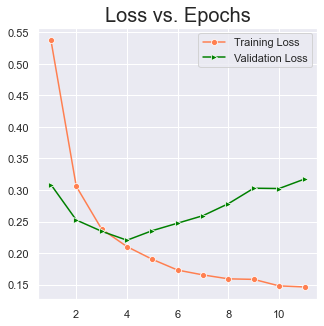

29/29 [==============================] - 0s 3ms/step - loss: 0.2593 - accuracy: 0.9277
Testing Accuracy:  92.77108311653137

Train dataset shape: (21912, 57019), 
Test dataset shape: (913, 57019)

Features Train dataset shape: (21912, 15000), 
FeaturesTest dataset shape: (913, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.87295, saving model to models\binary_classfiier\dl\merged_descr\model_15.h5

Epoch 00002: val_accuracy improved from 0.87295 to 0.89376, saving model to models\binary_classfiier\dl\merged_descr\model_15.h5

Epoch 00003: val_accuracy improved from 0.89376 to 0.89814, saving model to models\binary_classfiier\dl\merged_descr\model_15.h5

Epoch 00004: val_accuracy improved from 0.89814 to 0.91019, saving model to models\binary_classfiier\dl\merged_descr\model_15.h5

Epoch 00005: val_accuracy did not improve from 0.91019

Epoch 00006: val_accuracy did not improve from 0.91019

Epoch 00007: val_accuracy improved from 0.91019 to 0.91676, saving model to models\bi

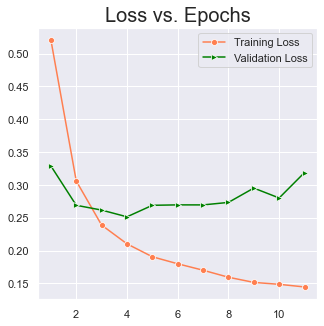

29/29 [==============================] - 0s 2ms/step - loss: 0.2952 - accuracy: 0.9189
Testing Accuracy:  91.89485311508179

Train dataset shape: (21912, 56766), 
Test dataset shape: (913, 56766)

Features Train dataset shape: (21912, 15000), 
FeaturesTest dataset shape: (913, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.84228, saving model to models\binary_classfiier\dl\merged_descr\model_16.h5

Epoch 00002: val_accuracy improved from 0.84228 to 0.87185, saving model to models\binary_classfiier\dl\merged_descr\model_16.h5

Epoch 00003: val_accuracy improved from 0.87185 to 0.88280, saving model to models\binary_classfiier\dl\merged_descr\model_16.h5

Epoch 00004: val_accuracy improved from 0.88280 to 0.89923, saving model to models\binary_classfiier\dl\merged_descr\model_16.h5

Epoch 00005: val_accuracy improved from 0.89923 to 0.90033, saving model to models\binary_classfiier\dl\merged_descr\model_16.h5

Epoch 00006: val_accuracy did not improve from 0.90033

Epoch 00007

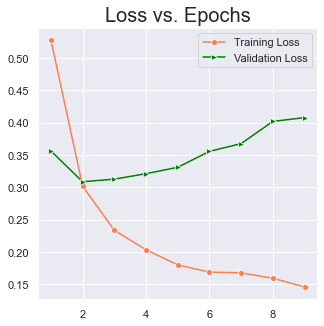

29/29 [==============================] - 0s 3ms/step - loss: 0.3307 - accuracy: 0.9003
Testing Accuracy:  90.03285765647888

Train dataset shape: (21912, 56730), 
Test dataset shape: (913, 56730)

Features Train dataset shape: (21912, 15000), 
FeaturesTest dataset shape: (913, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.86418, saving model to models\binary_classfiier\dl\merged_descr\model_17.h5

Epoch 00002: val_accuracy improved from 0.86418 to 0.89814, saving model to models\binary_classfiier\dl\merged_descr\model_17.h5

Epoch 00003: val_accuracy improved from 0.89814 to 0.90581, saving model to models\binary_classfiier\dl\merged_descr\model_17.h5

Epoch 00004: val_accuracy did not improve from 0.90581

Epoch 00005: val_accuracy improved from 0.90581 to 0.90800, saving model to models\binary_classfiier\dl\merged_descr\model_17.h5

Epoch 00006: val_accuracy improved from 0.90800 to 0.92004, saving model to models\binary_classfiier\dl\merged_descr\model_17.h5

Epoch 00007

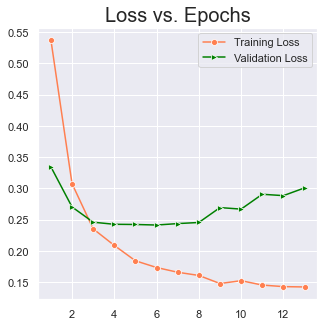

29/29 [==============================] - 0s 3ms/step - loss: 0.2669 - accuracy: 0.9233
Testing Accuracy:  92.33297109603882

Train dataset shape: (21912, 56977), 
Test dataset shape: (913, 56977)

Features Train dataset shape: (21912, 15000), 
FeaturesTest dataset shape: (913, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.88828, saving model to models\binary_classfiier\dl\merged_descr\model_18.h5

Epoch 00002: val_accuracy improved from 0.88828 to 0.89047, saving model to models\binary_classfiier\dl\merged_descr\model_18.h5

Epoch 00003: val_accuracy improved from 0.89047 to 0.90471, saving model to models\binary_classfiier\dl\merged_descr\model_18.h5

Epoch 00004: val_accuracy did not improve from 0.90471

Epoch 00005: val_accuracy improved from 0.90471 to 0.90581, saving model to models\binary_classfiier\dl\merged_descr\model_18.h5

Epoch 00006: val_accuracy did not improve from 0.90581

Epoch 00007: val_accuracy did not improve from 0.90581

Epoch 00008: val_accuracy did

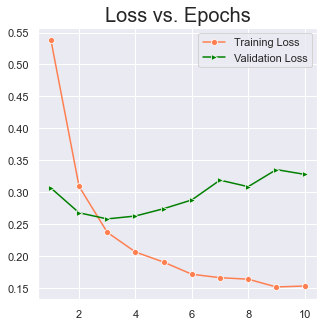

29/29 [==============================] - 0s 3ms/step - loss: 0.3280 - accuracy: 0.9168
Testing Accuracy:  91.67579412460327

Train dataset shape: (21912, 56536), 
Test dataset shape: (913, 56536)

Features Train dataset shape: (21912, 15000), 
FeaturesTest dataset shape: (913, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.87404, saving model to models\binary_classfiier\dl\merged_descr\model_19.h5

Epoch 00002: val_accuracy improved from 0.87404 to 0.89376, saving model to models\binary_classfiier\dl\merged_descr\model_19.h5

Epoch 00003: val_accuracy improved from 0.89376 to 0.90142, saving model to models\binary_classfiier\dl\merged_descr\model_19.h5

Epoch 00004: val_accuracy improved from 0.90142 to 0.91128, saving model to models\binary_classfiier\dl\merged_descr\model_19.h5

Epoch 00005: val_accuracy did not improve from 0.91128

Epoch 00006: val_accuracy improved from 0.91128 to 0.91238, saving model to models\binary_classfiier\dl\merged_descr\model_19.h5

Epoch 00007

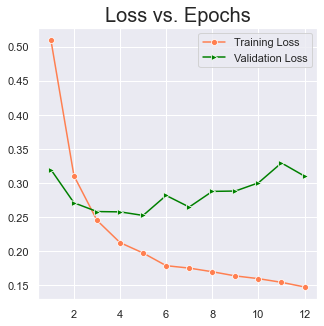

29/29 [==============================] - 0s 3ms/step - loss: 0.2647 - accuracy: 0.9189
Testing Accuracy:  91.89485311508179

Train dataset shape: (21912, 56990), 
Test dataset shape: (913, 56990)

Features Train dataset shape: (21912, 15000), 
FeaturesTest dataset shape: (913, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.84885, saving model to models\binary_classfiier\dl\merged_descr\model_20.h5

Epoch 00002: val_accuracy improved from 0.84885 to 0.87514, saving model to models\binary_classfiier\dl\merged_descr\model_20.h5

Epoch 00003: val_accuracy improved from 0.87514 to 0.89376, saving model to models\binary_classfiier\dl\merged_descr\model_20.h5

Epoch 00004: val_accuracy did not improve from 0.89376

Epoch 00005: val_accuracy did not improve from 0.89376

Epoch 00006: val_accuracy improved from 0.89376 to 0.89704, saving model to models\binary_classfiier\dl\merged_descr\model_20.h5

Epoch 00007: val_accuracy did not improve from 0.89704

Epoch 00008: val_accuracy did

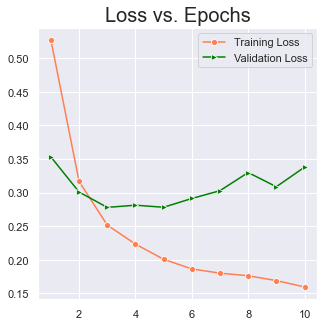

29/29 [==============================] - 0s 3ms/step - loss: 0.3088 - accuracy: 0.9014
Testing Accuracy:  90.14238715171814

Train dataset shape: (21912, 56914), 
Test dataset shape: (913, 56914)

Features Train dataset shape: (21912, 15000), 
FeaturesTest dataset shape: (913, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.85871, saving model to models\binary_classfiier\dl\merged_descr\model_21.h5

Epoch 00002: val_accuracy improved from 0.85871 to 0.89266, saving model to models\binary_classfiier\dl\merged_descr\model_21.h5

Epoch 00003: val_accuracy improved from 0.89266 to 0.90252, saving model to models\binary_classfiier\dl\merged_descr\model_21.h5

Epoch 00004: val_accuracy improved from 0.90252 to 0.90361, saving model to models\binary_classfiier\dl\merged_descr\model_21.h5

Epoch 00005: val_accuracy did not improve from 0.90361

Epoch 00006: val_accuracy improved from 0.90361 to 0.91128, saving model to models\binary_classfiier\dl\merged_descr\model_21.h5

Epoch 00007

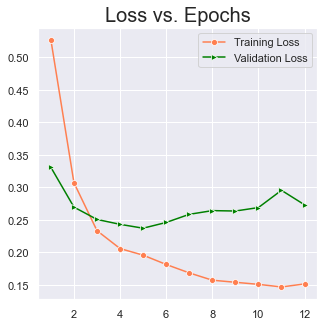

29/29 [==============================] - 0s 3ms/step - loss: 0.2733 - accuracy: 0.9189
Testing Accuracy:  91.89485311508179

Train dataset shape: (21912, 56722), 
Test dataset shape: (913, 56722)

Features Train dataset shape: (21912, 15000), 
FeaturesTest dataset shape: (913, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.85871, saving model to models\binary_classfiier\dl\merged_descr\model_22.h5

Epoch 00002: val_accuracy improved from 0.85871 to 0.89047, saving model to models\binary_classfiier\dl\merged_descr\model_22.h5

Epoch 00003: val_accuracy improved from 0.89047 to 0.90033, saving model to models\binary_classfiier\dl\merged_descr\model_22.h5

Epoch 00004: val_accuracy did not improve from 0.90033

Epoch 00005: val_accuracy improved from 0.90033 to 0.90142, saving model to models\binary_classfiier\dl\merged_descr\model_22.h5

Epoch 00006: val_accuracy did not improve from 0.90142

Epoch 00007: val_accuracy improved from 0.90142 to 0.91238, saving model to models\bi

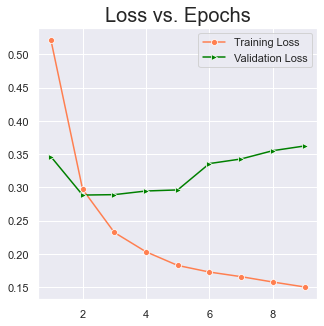

29/29 [==============================] - 0s 2ms/step - loss: 0.3622 - accuracy: 0.9135
Testing Accuracy:  91.3472056388855

Train dataset shape: (21912, 56982), 
Test dataset shape: (913, 56982)

Features Train dataset shape: (21912, 15000), 
FeaturesTest dataset shape: (913, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.85871, saving model to models\binary_classfiier\dl\merged_descr\model_23.h5

Epoch 00002: val_accuracy improved from 0.85871 to 0.88719, saving model to models\binary_classfiier\dl\merged_descr\model_23.h5

Epoch 00003: val_accuracy improved from 0.88719 to 0.89376, saving model to models\binary_classfiier\dl\merged_descr\model_23.h5

Epoch 00004: val_accuracy improved from 0.89376 to 0.90581, saving model to models\binary_classfiier\dl\merged_descr\model_23.h5

Epoch 00005: val_accuracy did not improve from 0.90581

Epoch 00006: val_accuracy improved from 0.90581 to 0.91238, saving model to models\binary_classfiier\dl\merged_descr\model_23.h5

Epoch 00007:

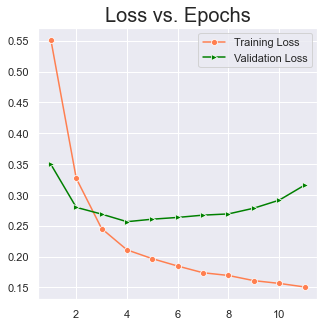

29/29 [==============================] - 0s 2ms/step - loss: 0.2692 - accuracy: 0.9157
Testing Accuracy:  91.56626462936401

Train dataset shape: (21912, 57002), 
Test dataset shape: (913, 57002)

Features Train dataset shape: (21912, 15000), 
FeaturesTest dataset shape: (913, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.86418, saving model to models\binary_classfiier\dl\merged_descr\model_24.h5

Epoch 00002: val_accuracy improved from 0.86418 to 0.88061, saving model to models\binary_classfiier\dl\merged_descr\model_24.h5

Epoch 00003: val_accuracy improved from 0.88061 to 0.88609, saving model to models\binary_classfiier\dl\merged_descr\model_24.h5

Epoch 00004: val_accuracy improved from 0.88609 to 0.89704, saving model to models\binary_classfiier\dl\merged_descr\model_24.h5

Epoch 00005: val_accuracy improved from 0.89704 to 0.89923, saving model to models\binary_classfiier\dl\merged_descr\model_24.h5

Epoch 00006: val_accuracy did not improve from 0.89923

Epoch 00007

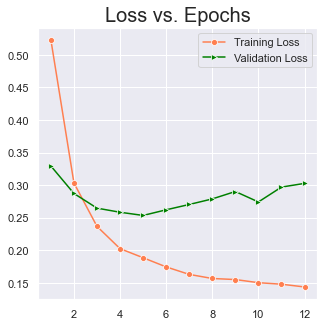

29/29 [==============================] - 0s 3ms/step - loss: 0.3027 - accuracy: 0.9135
Testing Accuracy:  91.3472056388855

Train dataset shape: (21912, 56765), 
Test dataset shape: (913, 56765)

Features Train dataset shape: (21912, 15000), 
FeaturesTest dataset shape: (913, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.86637, saving model to models\binary_classfiier\dl\merged_descr\model_25.h5

Epoch 00002: val_accuracy improved from 0.86637 to 0.87623, saving model to models\binary_classfiier\dl\merged_descr\model_25.h5

Epoch 00003: val_accuracy improved from 0.87623 to 0.89047, saving model to models\binary_classfiier\dl\merged_descr\model_25.h5

Epoch 00004: val_accuracy improved from 0.89047 to 0.90252, saving model to models\binary_classfiier\dl\merged_descr\model_25.h5

Epoch 00005: val_accuracy did not improve from 0.90252

Epoch 00006: val_accuracy did not improve from 0.90252

Epoch 00007: val_accuracy improved from 0.90252 to 0.90471, saving model to models\bin

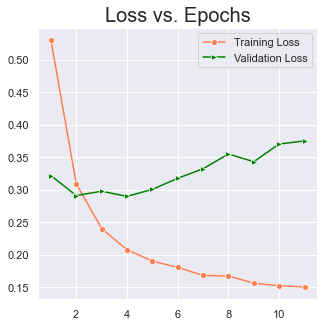

29/29 [==============================] - 0s 3ms/step - loss: 0.3704 - accuracy: 0.9124
Testing Accuracy:  91.23767614364624


In [71]:
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction.text import TfidfVectorizer


def get_model_name(k):
    return f'model_{k}.h5'

NUM_SPLITS = 25
EPOCHS = 50
save_dir = Path('./models/binary_classfiier/dl/merged_descr')
fold_var = 1
NGRAM_RANGE = (1, 2)
TOP_K = 15000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2
NUM_CLASSES = 2

kwargs = {
        'ngram_range' : NGRAM_RANGE,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : TOKEN_MODE,
        'min_df' : MIN_DOC_FREQ
    }

val_accs = []
skf = StratifiedKFold(n_splits=NUM_SPLITS, shuffle=True, random_state=seed)

for train_indices, test_indices in skf.split(X, y):
    X_train_split, X_test_split = X[train_indices], X[test_indices]
    y_train_split, y_test_split = y[train_indices], y[test_indices]
    vectorizer = TfidfVectorizer(**kwargs)
    X_train_vec = vectorizer.fit_transform(X_train_split)
    X_test_vec = vectorizer.transform(X_test_split)
    print(f"\nTrain dataset shape: {X_train_vec.shape}, \nTest dataset shape: {X_test_vec.shape}")

    selector = SelectKBest(f_classif, k=min(TOP_K, X_train_vec.shape[1]))
    selector.fit(X_train_vec, y_train_split)
    X_train_vec = selector.transform(X_train_vec).astype('float32')
    X_test_vec = selector.transform(X_test_vec).astype('float32')
    X_train_vec = X_train_vec.toarray()
    X_test_vec = X_test_vec.toarray()

    print(f"\nFeatures Train dataset shape: {X_train_vec.shape}, \nFeaturesTest dataset shape: {X_test_vec.shape}")
    model_ = None
    model_ = Sequential([   
        Dense(30, activation='relu', input_shape=X_train_vec.shape[1:]),
        Dropout(0.5),
        Dense(20, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model_.compile(
        loss = 'binary_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy']
    )
    
    checkpoint = tensorflow.keras.callbacks.ModelCheckpoint(save_dir / get_model_name(fold_var),
                                                            monitor='val_accuracy',
                                                            verbose=1,
                                                            save_best_only=True,
                                                            mode='max')

    h_ = model_.fit(
            X_train_vec, y_train_split,
            validation_data = (X_test_vec, y_test_split),  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [checkpoint, early_stop, lr_reduce_on_plateau],
            verbose = False)
    
    model_.load_weights(save_dir / get_model_name(fold_var))
    plot_learning_curve(h_)
    loss, acc = model_.evaluate(X_test_vec, y_test_split)
    print("Testing Accuracy: ", acc*100)
    val_accs.append(acc)
    tensorflow.keras.backend.clear_session()
    fold_var += 1

In [72]:
print("Testing Accuracy: ", np.mean(val_accs)*100)   # average k fold accuracy

Testing Accuracy:  91.39539909362793


<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Metrics: </span></strong></li>
</ul></h3>

<table style="width:100%">
  <tr>
    <th>Model</th>
    <th>Test Accuracy</th>
  </tr>
  <tr>
    <td>Simple Feed-Forward Net using Embedding Layer</td>
    <td>88.08%</td>
  </tr>
<tr>
    <td>Feed-Forward NN + Batch Norm</td>
    <td>87.21%</td>
  </tr>
<tr>
    <td>Feed-Forward NN + Dropout</td>
    <td>89.80%</td>
  </tr>
    <tr>
    <td>Feed-Forward NN + Pre-trained GloVe embeddings</td>
    <td>86.40%</td>
  </tr>
  <tr>
    <td>LSTM</td>
    <td>90.51%</td>
  </tr>
    
  <tr>
    <td>Bi-Directional LSTM</td>
    <td>89.43%</td>
  </tr>
<tr>
    <td>Convolution Blocks (Dimensionality Reduction) + LSTM</td>
    <td>90.19%</td>
  </tr>
    <tr>
    <td>Convolution Blocks (Dimensionality Reduction) + Bi-LSTM</td>
    <td>89.57%</td>
  </tr>
<tr>
    <td>TfIdf Vectors + Feature Selection + Feed-forward Neural Net</td>
    <td>84.35%</td>
  </tr>
<tr>
    <td>Stratified KFold Validation + TfIdf Vectors + Feature Selection + +Feed-forward Neural Net</td>
    <td>91.40%</td>
  </tr>
</table>